# Predicting Income based on US census dataset

## Context and Objective

The objective is to predict individual yearly income, based on US government census dataset containing 41 features such as age, degree, etc... <br>
Income per person is a binary variable, worth either over or under $50,000 per year.<br>
This is a supervised classification problem, so we will use various machine learning algorithms to perform the prediction.<br>

This notebook follows the below approach:
1. Data Import and mapping
2. Univariate Data Analysis
3. Correlation Analysis
4. Baseline processing with a simple linear classifier
5. Model Selection
6. Features Selection
7. Final Model validation and result discussion


## 1. Data Import and Header mapping

First we need to import some libraries. We are using Numpy/Pandas/Scikit-learn

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

Let's import the learn data file in a dataframe. 

In [2]:
df = pd.read_csv('./us_census_full/census_income_learn.csv',index_col=False, header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


Now we need to identify the column names. In the metadata file, we can find a list of effective fields like this one :<br>
|   91 distinct values for attribute #0 (age) continuous
By comparing the list of fields with the first lines of the training data we can see that they do not match.<br>
At the end of the metadata file, we can find that one field was ignored in the field list: | instance weight: ignore. By adding this field to the field list, we can perfectly map the data with the field list.<br>
Here is a screenshot of the manual field mapping (green = mapped, orange = unmapped):

<img src="manual_mapping.png" alt="Drawing" style="width: 720px;" align="center"/><center>

Finally, let's double check our mapping by comparing the data in the above table with the possible values, which are also provided in the meta data file. It is better to be 100% sure of the mapping now rather than later in the process. <br> Now we have the column names, we can create a .csv file with the list as well as the data type (nominal vs. continuous) and use it as header for the training data.

In [3]:
mapping = pd.read_csv('./us_census_full/census_income_header.csv',header =None, names = ['feat','type','nb'], index_col=False)
mapping.head(5)

,feat,type,nb
0,age,continuous,91
1,class of worker,nominal,9
2,detailed industry recode,nominal,52
3,detailed occupation recode,nominal,47
4,education,nominal,17


In [4]:
df.columns = mapping['feat'].tolist()
df['income'] = pd.factorize(df['income'])[0]
df.head(5)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


Data looks good. Now we are ready to take a closer look at it.

## 2. Univariate Data analysis 

For each continuous data we compute histogram and stats and for each categorical data we count the number of value per category.<br>
Let's start by the continuous features:

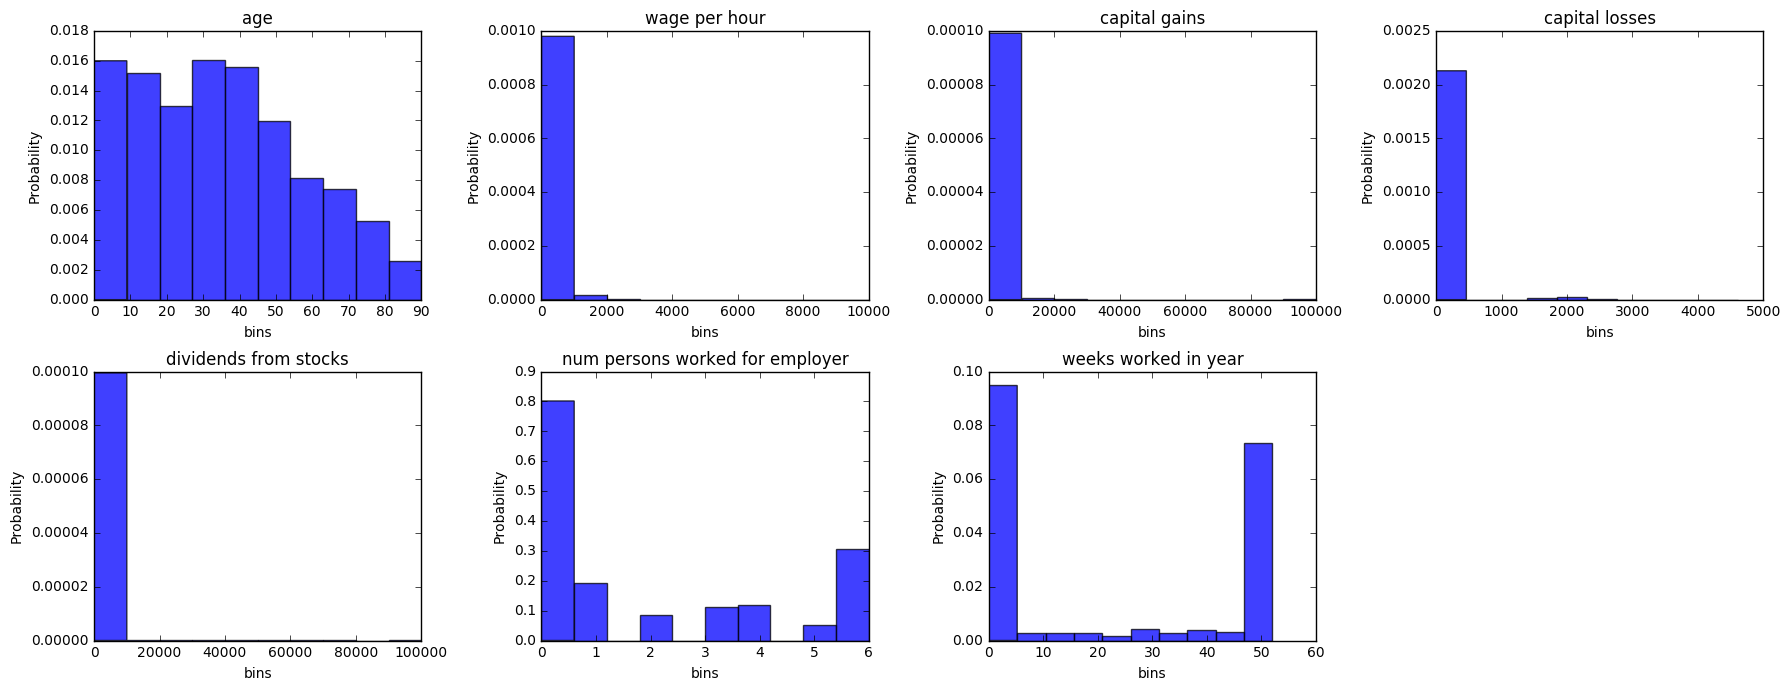

In [5]:
plt.gcf().clear()
list_continuous_feat = mapping[mapping['type'] == 'continuous']['feat'].tolist()
nb_continuous_feat = len(list_continuous_feat)
fig = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
total_nb = len( df)
for i in range(nb_continuous_feat-1) :

    feat = list_continuous_feat[i]
    ax1 = fig.add_subplot(int(nb_continuous_feat/4)+1,4,i+1)
    ax1.hist(df[feat].tolist(), 10, normed=1, facecolor='blue', alpha=0.75)
    ax1.set_xlabel('bins')
    ax1.set_ylabel('Probability')
    ax1.set_title(feat)

plt.tight_layout()
plt.show()

'Age' is well distributed, as expected. 'weeks worked in year' is more binary : when you work, you are very likely to work full time (50 weeks a year).<br>
Capital gains, losses and dividends are mostly at 0, as only a small proportion of people have access to this kind of investment (stocks, bonds, etc...)

Let's compute some stats:

In [6]:
for i in range(nb_continuous_feat-1) :
    feat = list_continuous_feat[i]
    print(feat,'- Min:', min(df[feat]), ', Max:', max(df[feat]), ', Avg: %.1f' %np.mean(df[feat]),\
          ', Std: %.1f' % np.std(df[feat]), ', Nb zeros:', sum(df[feat]==0) )

age - Min: 0 , Max: 90 , Avg: 34.5 , Std: 22.3 , Nb zeros: 2839
wage per hour - Min: 0 , Max: 9999 , Avg: 55.4 , Std: 274.9 , Nb zeros: 188219
capital gains - Min: 0 , Max: 99999 , Avg: 434.7 , Std: 4697.5 , Nb zeros: 192144
capital losses - Min: 0 , Max: 4608 , Avg: 37.3 , Std: 271.9 , Nb zeros: 195617
dividends from stocks - Min: 0 , Max: 99999 , Avg: 197.5 , Std: 1984.2 , Nb zeros: 178382
num persons worked for employer - Min: 0 , Max: 6 , Avg: 2.0 , Std: 2.4 , Nb zeros: 95983
weeks worked in year - Min: 0 , Max: 52 , Avg: 23.2 , Std: 24.4 , Nb zeros: 95983


Some features are pretty sparse but we need to keep them as they look like good income predictors.
And now let's plot the categorical features:

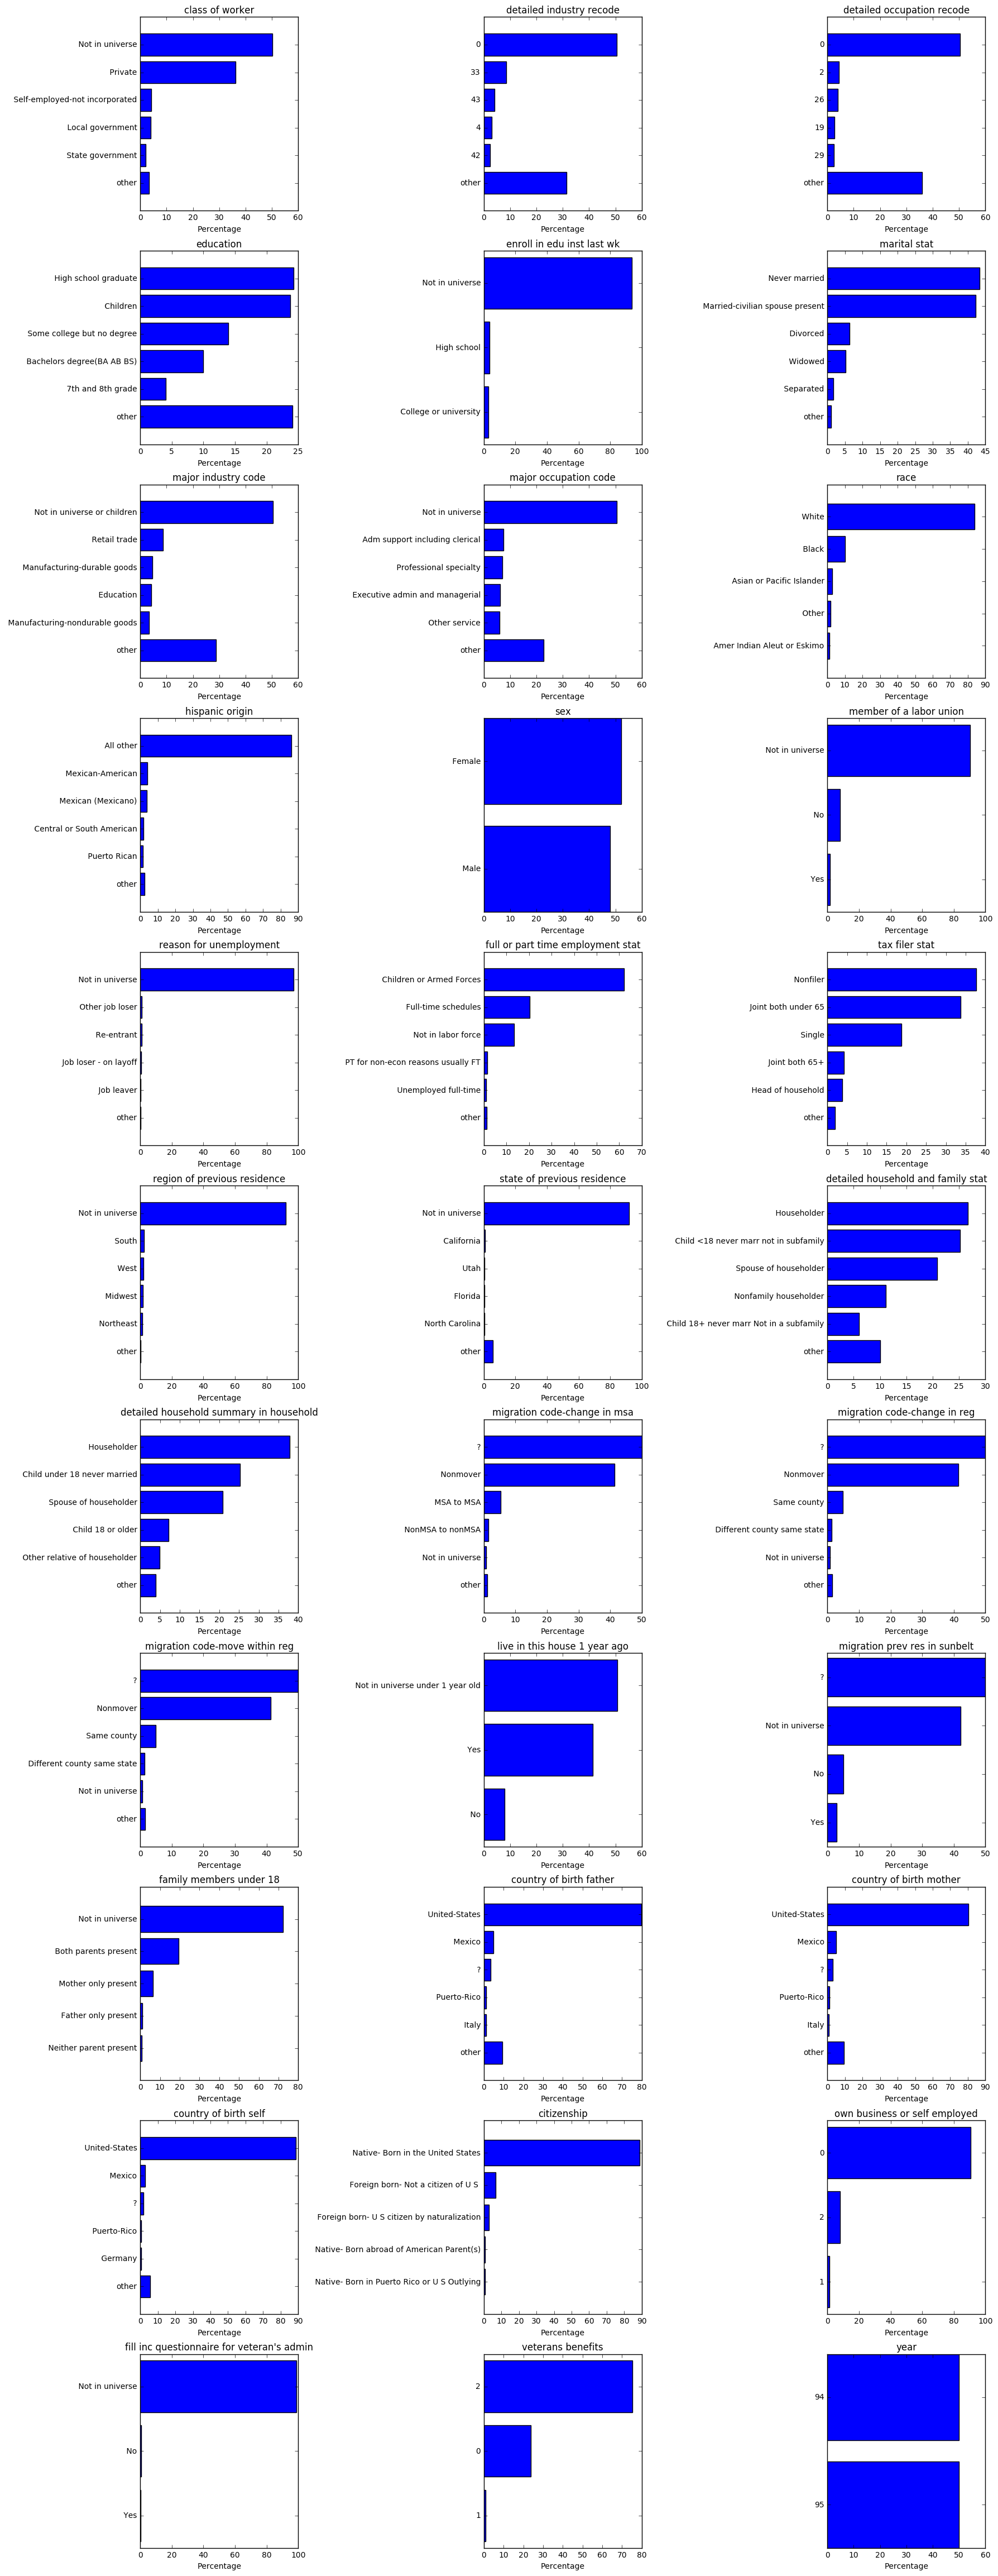

In [7]:
plt.gcf().clear()
list_categorical_feat = mapping[mapping['type'] == 'nominal']['feat'].tolist()
nb_categorical_feat = len(list_categorical_feat)
fig = plt.figure(figsize=(18, 50), dpi= 80, facecolor='w', edgecolor='k')

total_nb = len( df)
for i in range(nb_categorical_feat) :
    feat = list_categorical_feat[i]
    ax1 = fig.add_subplot(int(nb_categorical_feat/3)+1,3,i+1)
    
    #let's build a list of all possible values as well as their count
    values = df[feat].unique()
    values_count = [(value,len(df[feat][df[feat]==value])/total_nb*100) for value in values]
    
    #let's sort by size
    sorted_values = sorted(values_count, key=lambda tup: tup[1], reverse=True)
    
    # we keep the top5 and complete it by the 'other' label

    labels = [sorted_values[i][0] for i in range(min(len(sorted_values),5))]
    sizes = [sorted_values[i][1] for i in range(min(len(sorted_values),5))]
    
    if len(sorted_values) > 5 : 
        labels.append('other')
        sizes.append(np.sum( [sorted_values[i][1] for i in range(5,len(sorted_values))] ))   
    
    y_pos = np.arange(len(labels))
    ax1.barh(y_pos, sizes, align='center', color='blue', ecolor='black')
    ax1.set_title(feat);
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Percentage')

plt.tight_layout()
plt.show()

As we can see, 'Not in universe' and '?' are frequent occurences. Let's count the numbers per categorical variables:

In [8]:
for feat in list_categorical_feat :
    print(feat,'- Count "?":' ,sum(df[feat].astype(str)==' ?') , ', Count "Not in universe":', sum(df[feat].astype(str)==' Not in universe'))
    

class of worker - Count "?": 0 , Count "Not in universe": 100245
detailed industry recode - Count "?": 0 , Count "Not in universe": 0
detailed occupation recode - Count "?": 0 , Count "Not in universe": 0
education - Count "?": 0 , Count "Not in universe": 0
enroll in edu inst last wk - Count "?": 0 , Count "Not in universe": 186943
marital stat - Count "?": 0 , Count "Not in universe": 0
major industry code - Count "?": 0 , Count "Not in universe": 0
major occupation code - Count "?": 0 , Count "Not in universe": 100684
race - Count "?": 0 , Count "Not in universe": 0
hispanic origin - Count "?": 0 , Count "Not in universe": 0
sex - Count "?": 0 , Count "Not in universe": 0
member of a labor union - Count "?": 0 , Count "Not in universe": 180459
reason for unemployment - Count "?": 0 , Count "Not in universe": 193453
full or part time employment stat - Count "?": 0 , Count "Not in universe": 0
tax filer stat - Count "?": 0 , Count "Not in universe": 0
region of previous residence - Co

Some features like 'region of previous residence' or 'fill inc questionnaire for veteran's admin' are mostly not in universe. That does not mean that we should remove them now as they could still carry predictive power for some special cases.

## 3. Pairwise Correlation Analysis

We can find if some of the variables are redundant.
For this we perform direct correlation analysis on continuous data and on One Hot encoded categorical data.

In [9]:
continuous_df = df[list_continuous_feat[:-1]]
continuous_df.corr()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
age,1.000000,0.036938,0.053590,0.063351,0.104976,0.140887,0.206181
wage per hour,0.036938,1.000000,-0.001082,0.010993,-0.005731,0.191543,0.195687
capital gains,0.053590,-0.001082,1.000000,-0.012700,0.131476,0.058015,0.083549
capital losses,0.063351,0.010993,-0.012700,1.000000,0.042427,0.084255,0.100762
dividends from stocks,0.104976,-0.005731,0.131476,0.042427,1.000000,0.007206,0.013823
num persons worked for employer,0.140887,0.191543,0.058015,0.084255,0.007206,1.000000,0.747302
weeks worked in year,0.206181,0.195687,0.083549,0.100762,0.013823,0.747302,1.000000


The only obvious correlation is between 'num persons worked for employer' and 'weeks worked in year'.
These correlation could be useful to perfom PCA and dimensionality reduction. But for now, given the dataset size and number of features, it is better to keep the original features for analysis purpose.<br>
Now let's see the correlations on categorical data. This time let's display only perfect correlations or anticorrelations, and filter each half-pair :

In [10]:
correls = pd.get_dummies(df[list_categorical_feat].astype(str)).corr()
correlated_pairs = []
for feat1 in correls.columns :
    for feat2 in correls.columns :
        if feat2 == feat1 : break
        if abs(correls[feat1][feat2]) > 0.9999 :
            correlated_pairs.append((feat1,feat2))
for i in range(5):
    feat1,feat2 = correlated_pairs[i]
    print(feat1,'|',feat2,'|', correls[feat1][feat2])

detailed occupation recode_0 | detailed industry recode_0 | 1.0
detailed occupation recode_46 | detailed industry recode_51 | 1.0
major industry code_ Armed Forces | detailed industry recode_51 | 1.0
major industry code_ Armed Forces | detailed occupation recode_46 | 1.0
major industry code_ Communications | detailed industry recode_30 | 1.0


These results will be useful to filter redundant features when using One Hot encoding.
Let's put them in a list for later :

In [11]:
filter_OHE = np.unique([item2 for item1,item2 in correlated_pairs]).tolist()
filter_OHE

['class of worker_ Never worked',
 'country of birth self_ United-States',
 'detailed industry recode_0',
 'detailed industry recode_29',
 'detailed industry recode_3',
 'detailed industry recode_30',
 'detailed industry recode_31',
 'detailed industry recode_32',
 'detailed industry recode_33',
 'detailed industry recode_36',
 'detailed industry recode_39',
 'detailed industry recode_4',
 'detailed industry recode_40',
 'detailed industry recode_41',
 'detailed industry recode_42',
 'detailed industry recode_43',
 'detailed industry recode_44',
 'detailed industry recode_45',
 'detailed industry recode_46',
 'detailed industry recode_51',
 'detailed occupation recode_0',
 'detailed occupation recode_27',
 'detailed occupation recode_28',
 'detailed occupation recode_46',
 "fill inc questionnaire for veteran's admin_ Not in universe",
 'major industry code_ Armed Forces',
 'major industry code_ Not in universe or children',
 'migration code-change in msa_ ?',
 'migration code-change in

## 4. Predictive Analysis Baseline on continuous data

Before we can perform some work on the features and model, it is good to have a first baseline.<br>
Let's perform a simple Logistic regression. We train our model on 70% of the learning dataset and test it on the remaining 30%. The testing dataset will be used to do final performance assessment instead of model selection. <br> NB: A better performance assessment could be done using a k-fold cross validation. Instead, we shuffle the data and run it 2 times (not represented here) to check that the variation between the runs is low.

In [12]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(shuffle(df[list_continuous_feat]), test_size = 0.3)
print(len(train_df),len(test_df))
train_df.head(5)

139666 59857


,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,income
140901,4,0,0,0,0,0,0,0
124771,15,0,0,0,0,1,12,0
85319,25,0,0,0,0,6,48,0
102841,37,777,0,0,0,6,52,0
63459,51,0,0,0,0,1,52,0


### Training

In [13]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
train_data = train_df.values
classifier.fit(train_data[:,:-1], train_data[:,-1] )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Testing

In [14]:
test_data = test_df.drop(['income'],axis = 1).values
prediction = classifier.predict(test_data)
conf = pd.crosstab(test_df['income'], prediction, rownames=['Test Data'], colnames=['Predictions->'])
print('Confusion matrix:')
print(conf,'\n')
print('Total Accuracy: %.1f%% ' %((conf[0][0]+conf[1][1])/len(test_data)*100 ) )
print('Accuracy when a low salary is predicted: %.1f%%' %(conf[0][0]/(conf[0][0]+conf[0][1])*100 )  )
print('Accuracy when a high salary is predicted: %.1f%%' %(conf[1][1]/(conf[1][0]+conf[1][1])*100 )  )
print('Percentage of correctly predicted low salaries: %.1f%%' %(conf[0][0]/(conf[0][0]+conf[1][0])*100 )  )
print('Percentage of correctly predicted high salaries: %.1f%%' %(conf[1][1]/(conf[0][1]+conf[1][1])*100 )  )

Confusion matrix:
Predictions->      0    1
Test Data                
0              55936  179
1               3118  624 

Total Accuracy: 94.5% 
Accuracy when a low salary is predicted: 94.7%
Accuracy when a high salary is predicted: 77.7%
Percentage of correctly predicted low salaries: 99.7%
Percentage of correctly predicted high salaries: 16.7%


Total Accuracy looks good at 94% but in reality the classifier misses a lot of high salaries (Percentage of correctly predicted high salaries = 17%).
At this stage, it is interesting to see the features importance. To be able to compare, we normalize the coefficent with the standard deviation of the input data:

In [15]:
print(np.stack([test_df.drop(['income'],axis = 1).columns.tolist(),np.std(test_data, 0)*classifier.coef_[0]]).transpose())

[['age' '0.820585334131995']
 ['wage per hour' '-0.06337723103379486']
 ['capital gains' '0.7710356304295836']
 ['capital losses' '0.2191428390073843']
 ['dividends from stocks' '0.5100317837982619']
 ['num persons worked for employer' '0.337529062311863']
 ['weeks worked in year' '1.530032872613528']]


The most important feature is the number of weeks worked in year. The more you work the higher your income is! 
The only surprising result is the 'wage per hour'. The higher your wage is and the higher your income would be.

## 5. Model Selection

In order to compare several scenarios, we code a function that allows various parameters in input and returns the model performance. <br>
We use 2 main models : Logistic Regression and Random Forest.
For each model, the function allows to set a regularization parameter (C for Logistic and number of trees for Random Forest)
We can also decide to use only continuous features, to use simple factorization or One Hot encoding for categorial features. <br>
Finally we can add any custom filter to remove some features. By default, previously computed redundant One Hot categories are filtered.

In [16]:
from sklearn.ensemble import RandomForestClassifier


###### Model Selection Function
# Input : model parameters and filters
# output : model testing result and features importance

def model_selection(args):
    
    model,reg,include_nominal_flag,one_hot_flag,filters = args
    
    # Classifier setup
    if model == 'LR' :
        classifier = LogisticRegression(C= reg)
    elif model == 'RF' :
        classifier = RandomForestClassifier(n_estimators=reg, n_jobs = 6)
    
    # Categorical Features processing
    if include_nominal_flag == False :
        #Applying input filter on feature
        new_df  = df.drop(filters, axis=1)
        train_df, test_df = train_test_split(shuffle(new_df[list_continuous_feat]), test_size = 0.3)
        
        
    else :   
        if one_hot_flag :    
            # we use pandas' get_dummies function to generate one hot encoding
            new_df = pd.concat([pd.get_dummies(df[list_categorical_feat].astype(str)),df[list_continuous_feat]], axis=1)
            # filtering OHE categories found during correlation analysis
            new_df = new_df.drop(filter_OHE, axis=1)
        else :
            new_df = df.copy()
            for feat in list_categorical_feat :
                new_df[feat] = pd.factorize(df[feat])[0]

        #Applying input filter on feature
        new_df  = new_df.drop(filters, axis=1)
        train_df, test_df = train_test_split(shuffle(new_df), test_size = 0.3)

    # Training
    train_data = train_df.values
    classifier.fit(train_data[:,:-1], train_data[:,-1] )
    
    # Testing
    test_data = test_df.drop(['income'],axis = 1).values
    prediction = classifier.predict(test_data)
    conf = pd.crosstab(test_df['income'], prediction, rownames=['Test Data'], colnames=['Predictions->']) 
    
    # Features Importance computation
    features_importance = []
    
    if model == 'LR' :       
        features_importance = np.stack([test_df.drop(['income'],axis = 1).columns.tolist(),np.std(test_data, 0)*classifier.coef_[0]]).transpose()
        features_importance = features_importance[np.abs(pd.to_numeric(features_importance[:,1])).argsort()[::-1]]

    elif model == 'RF' :
        sorted_indexes = np.argsort(classifier.feature_importances_)[::-1]
        for index in sorted_indexes :
            features_importance.append([test_df.drop(['income'],axis = 1).columns.tolist()[index],classifier.feature_importances_[index]])
        features_importance = np.array(features_importance)
    
    # End
    return conf,features_importance


Now let's build a dictionnary of arguments and run the function over them!
Ideally the regularization parameters would need more datapoints in order to optimize the model more thoroughly, but here we only keep 3 different parameters (C1,C2,C4 and 1,10,100 trees)

In [17]:
# create dictionnary of arguments
arg_dico = {
    'Linear_C1_NoCat(Baseline)' : ('LR',1,False,False,[]),
    'Linear_C2_NoCat' : ('LR',2,False,False,[]),    
    'Linear_C4_NoCat' : ('LR',4,False,False,[]),      
    'Linear_C1_FactorizedCat(Not recommended)' : ('LR',1,True,False,[]),
    'Linear_C1_OneHotEncoder' : ('LR',1,True,True,[]),    
    'Linear_C2_OneHotEncoder' : ('LR',2,True,True,[]),      
    'Linear_C4_OneHotEncoder' : ('LR',4,True,True,[]),
    'Forest_1tree_NoCat' : ('RF',1,False,False,[]),    
    'Forest_10tree_NoCat' : ('RF',10,False,False,[]),
    'Forest_100tree_NoCat' : ('RF',100,False,False,[]),    
    'Forest_1tree_FactorizedCat' : ('RF',1,True,False,[]),    
    'Forest_10tree_FactorizedCat' : ('RF',10,True,False,[]),
    'Forest_100tree_FactorizedCat' : ('RF',100,True,False,[]),      
    'Forest_1tree_OneHotEncoder' : ('RF',1,True,True,[]),    
    'Forest_10tree_OneHotEncoder' : ('RF',10,True,True,[]),
    'Forest_100tree_OneHotEncoder' : ('RF',100,True,True,[])
}

#initialize output
output = {}
stats_list = ['total_accuracy','accuracy_low_predicted' ,'accuracy_high_predicted',\
              'percent_of_correctly_predicted_low','percent_of_correctly_predicted_high']

for stat in stats_list :
    output[stat] = {}

feat_output = {}

#run model_selection function over the arguments
for arg in arg_dico :
    print('start...',arg)
    conf,feat_importance = model_selection(arg_dico[arg])
    output['total_accuracy'][arg] = (conf[0][0]+conf[1][1])/len(test_data)*100 
    output['accuracy_low_predicted'][arg] = (conf[0][0]/(conf[0][0]+conf[0][1])*100 )  
    output['accuracy_high_predicted'][arg] = (conf[1][1]/(conf[1][0]+conf[1][1])*100 )  
    output['percent_of_correctly_predicted_low'][arg] = (conf[0][0]/(conf[0][0]+conf[1][0])*100 )  
    output['percent_of_correctly_predicted_high'][arg] = (conf[1][1]/(conf[0][1]+conf[1][1])*100 ) 
    feat_output[arg] = feat_importance.tolist()



start... Forest_1tree_NoCat
start... Forest_100tree_FactorizedCat
start... Linear_C1_OneHotEncoder
start... Linear_C2_NoCat
start... Forest_10tree_OneHotEncoder
start... Linear_C2_OneHotEncoder
start... Linear_C4_OneHotEncoder
start... Forest_100tree_OneHotEncoder
start... Linear_C1_FactorizedCat(Not recommended)
start... Forest_100tree_NoCat
start... Forest_10tree_NoCat
start... Forest_1tree_FactorizedCat
start... Forest_10tree_FactorizedCat
start... Linear_C4_NoCat
start... Forest_1tree_OneHotEncoder
start... Linear_C1_NoCat(Baseline)


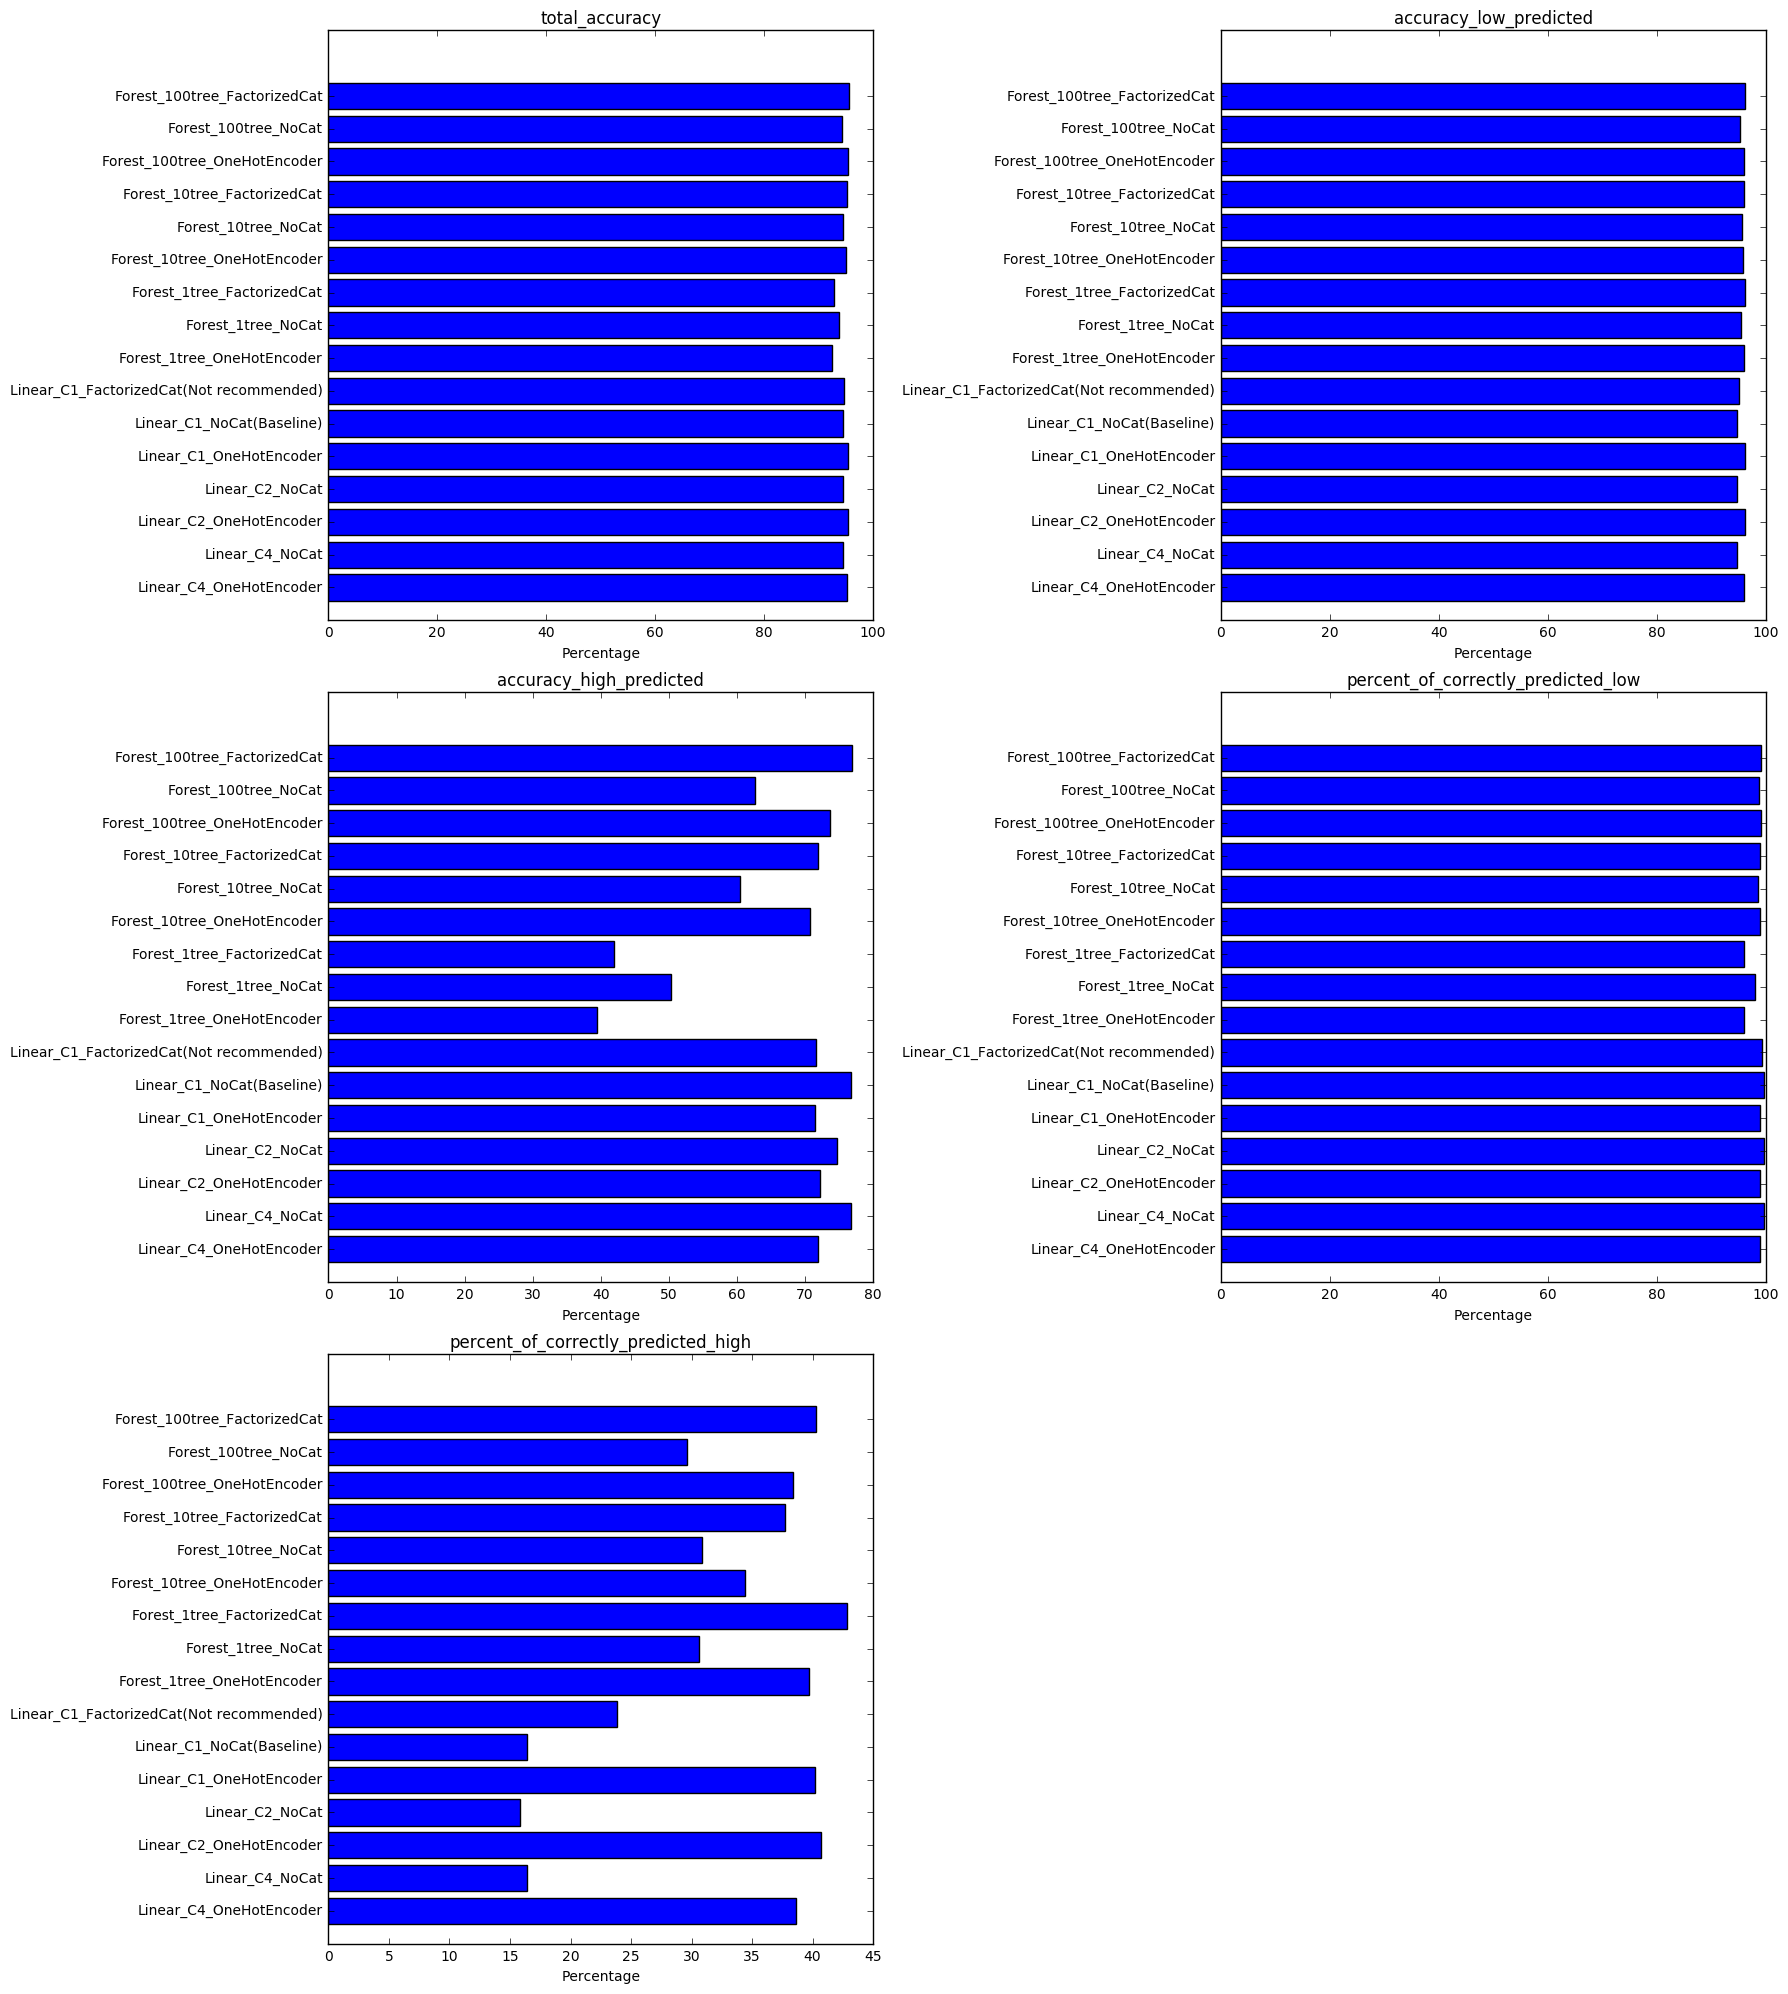

In [18]:
plt.gcf().clear()

fig = plt.figure(figsize=(18, 20), dpi= 80, facecolor='w', edgecolor='k')
total_nb = len( df)
for i in range(5) :

    stat = stats_list[i]
    ax1 = fig.add_subplot(3,2,i+1)
    
    labels = []
    sizes = []
    
    for arg in sorted(output[stat]) :
        labels.append(arg)
        sizes.append(output[stat][arg])
    
    y_pos = np.arange(len(labels))
    ax1.barh(y_pos, sizes, align='center', color='blue', ecolor='black')
    ax1.set_title(stat);
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Percentage')    
    
    
plt.tight_layout()
plt.show()

## Model Selection results

All models perform in a similar way for total_accuracy, accuracy_low_predicted and percent_of_correctly_predicted low.
So, to assess performance, important metrics are accuracy_high_predicted and percent_of_correctly_predicted_high.<br><br>
Here we can see that Linear_C2_OneHotEncoder and Forest_100tree_FactorizedCat are superior to the other ones.
Unsurprisingly, Logistic Regression needs One Hot encoding on categorical variables, whereas Random Forest is performing well on simple factorization.

# 6. Features Analysis and selection

In this chapter we analyse the features and select the most important one. The features weights were computed by the model selection function and put in 'feat_output'. <br> 
Let's start by the linear model:

In [19]:
feat_output['Linear_C2_OneHotEncoder'][:10]

[['weeks worked in year', '0.9629039721658843'],
 ['tax filer stat_ Nonfiler', '-0.7657406580988715'],
 ['age', '0.7178145034971891'],
 ['full or part time employment stat_ Children or Armed Forces',
  '-0.5416281118064525'],
 ['sex_ Male', '0.5299186941238827'],
 ['capital gains', '0.4777300667558974'],
 ['live in this house 1 year ago_ Not in universe under 1 year old',
  '-0.41161631063771376'],
 ['num persons worked for employer', '0.4058142525317519'],
 ['year_95', '-0.4006106425928747'],
 ['dividends from stocks', '0.37160600375661534']]

Let's put together a list of less important features :

In [20]:
linear_filter =[]
for feat,weight in feat_output['Linear_C2_OneHotEncoder'] :
    if abs(float(weight)) < 0.03 : linear_filter.append(feat)
linear_filter[:5]

['reason for unemployment_ Job loser - on layoff',
 'race_ Other',
 'major industry code_ Communications',
 'detailed industry recode_25',
 'country of birth mother_ Germany']

Now let's analyze the Random Forest features importance.

In [21]:
feat_output['Forest_100tree_FactorizedCat'][:10]

[['dividends from stocks', '0.0917005321318'],
 ['instance weight', '0.0908612117082'],
 ['age', '0.0897615153196'],
 ['capital gains', '0.0889044195167'],
 ['education', '0.0599456956446'],
 ['detailed occupation recode', '0.0591228363233'],
 ['major occupation code', '0.0554080226948'],
 ['detailed industry recode', '0.0512341581282'],
 ['major industry code', '0.0427476275683'],
 ['weeks worked in year', '0.0389151517719']]

Same thing, let's build a filter with non important features.

In [22]:
forest_filter =[]
for feat,weight in feat_output['Forest_100tree_FactorizedCat'] :
    if abs(float(weight)) < 0.02 : forest_filter.append(feat)
forest_filter[:5]

['detailed household and family stat',
 'tax filer stat',
 'marital stat',
 'country of birth father',
 'own business or self employed']

Now let's rerun the algos with and without the filters. We override the previous results for clarity purpose.

In [23]:
arg_dico = {
    'Linear_C2_OneHotEncoder' : ('LR',2,True,True,[]), 
    'Forest_100tree_FactorizedCat' : ('RF',100,True,False,[]) ,   
    'Linear_C2_OneHotEncoder_FILTER' : ('LR',2,True,True,linear_filter), 
    'Forest_100tree_FactorizedCat_FILTER' : ('RF',100,True,False,forest_filter)        
}

output = {}
stats_list = ['total_accuracy','accuracy_low_predicted' ,'accuracy_high_predicted',\
              'percent_of_correctly_predicted_low','percent_of_correctly_predicted_high']

for stat in stats_list :
    output[stat] = {}

feat_output = {}

#run the model selection algo over the arguments
for arg in arg_dico :
    start_time = time.time()
    conf,feat_importance = model_selection(arg_dico[arg])
    output['total_accuracy'][arg] = (conf[0][0]+conf[1][1])/len(test_data)*100 
    output['accuracy_low_predicted'][arg] = (conf[0][0]/(conf[0][0]+conf[0][1])*100 )  
    output['accuracy_high_predicted'][arg] = (conf[1][1]/(conf[1][0]+conf[1][1])*100 )  
    output['percent_of_correctly_predicted_low'][arg] = (conf[0][0]/(conf[0][0]+conf[1][0])*100 )  
    output['percent_of_correctly_predicted_high'][arg] = (conf[1][1]/(conf[0][1]+conf[1][1])*100 ) 
    feat_output[arg] = feat_importance.tolist()
    print('Processing time for '+arg+':', int(time.time()-start_time),'secs.' )


Processing time for Linear_C2_OneHotEncoder_FILTER: 11 secs.
Processing time for Forest_100tree_FactorizedCat: 10 secs.
Processing time for Forest_100tree_FactorizedCat_FILTER: 6 secs.
Processing time for Linear_C2_OneHotEncoder: 15 secs.


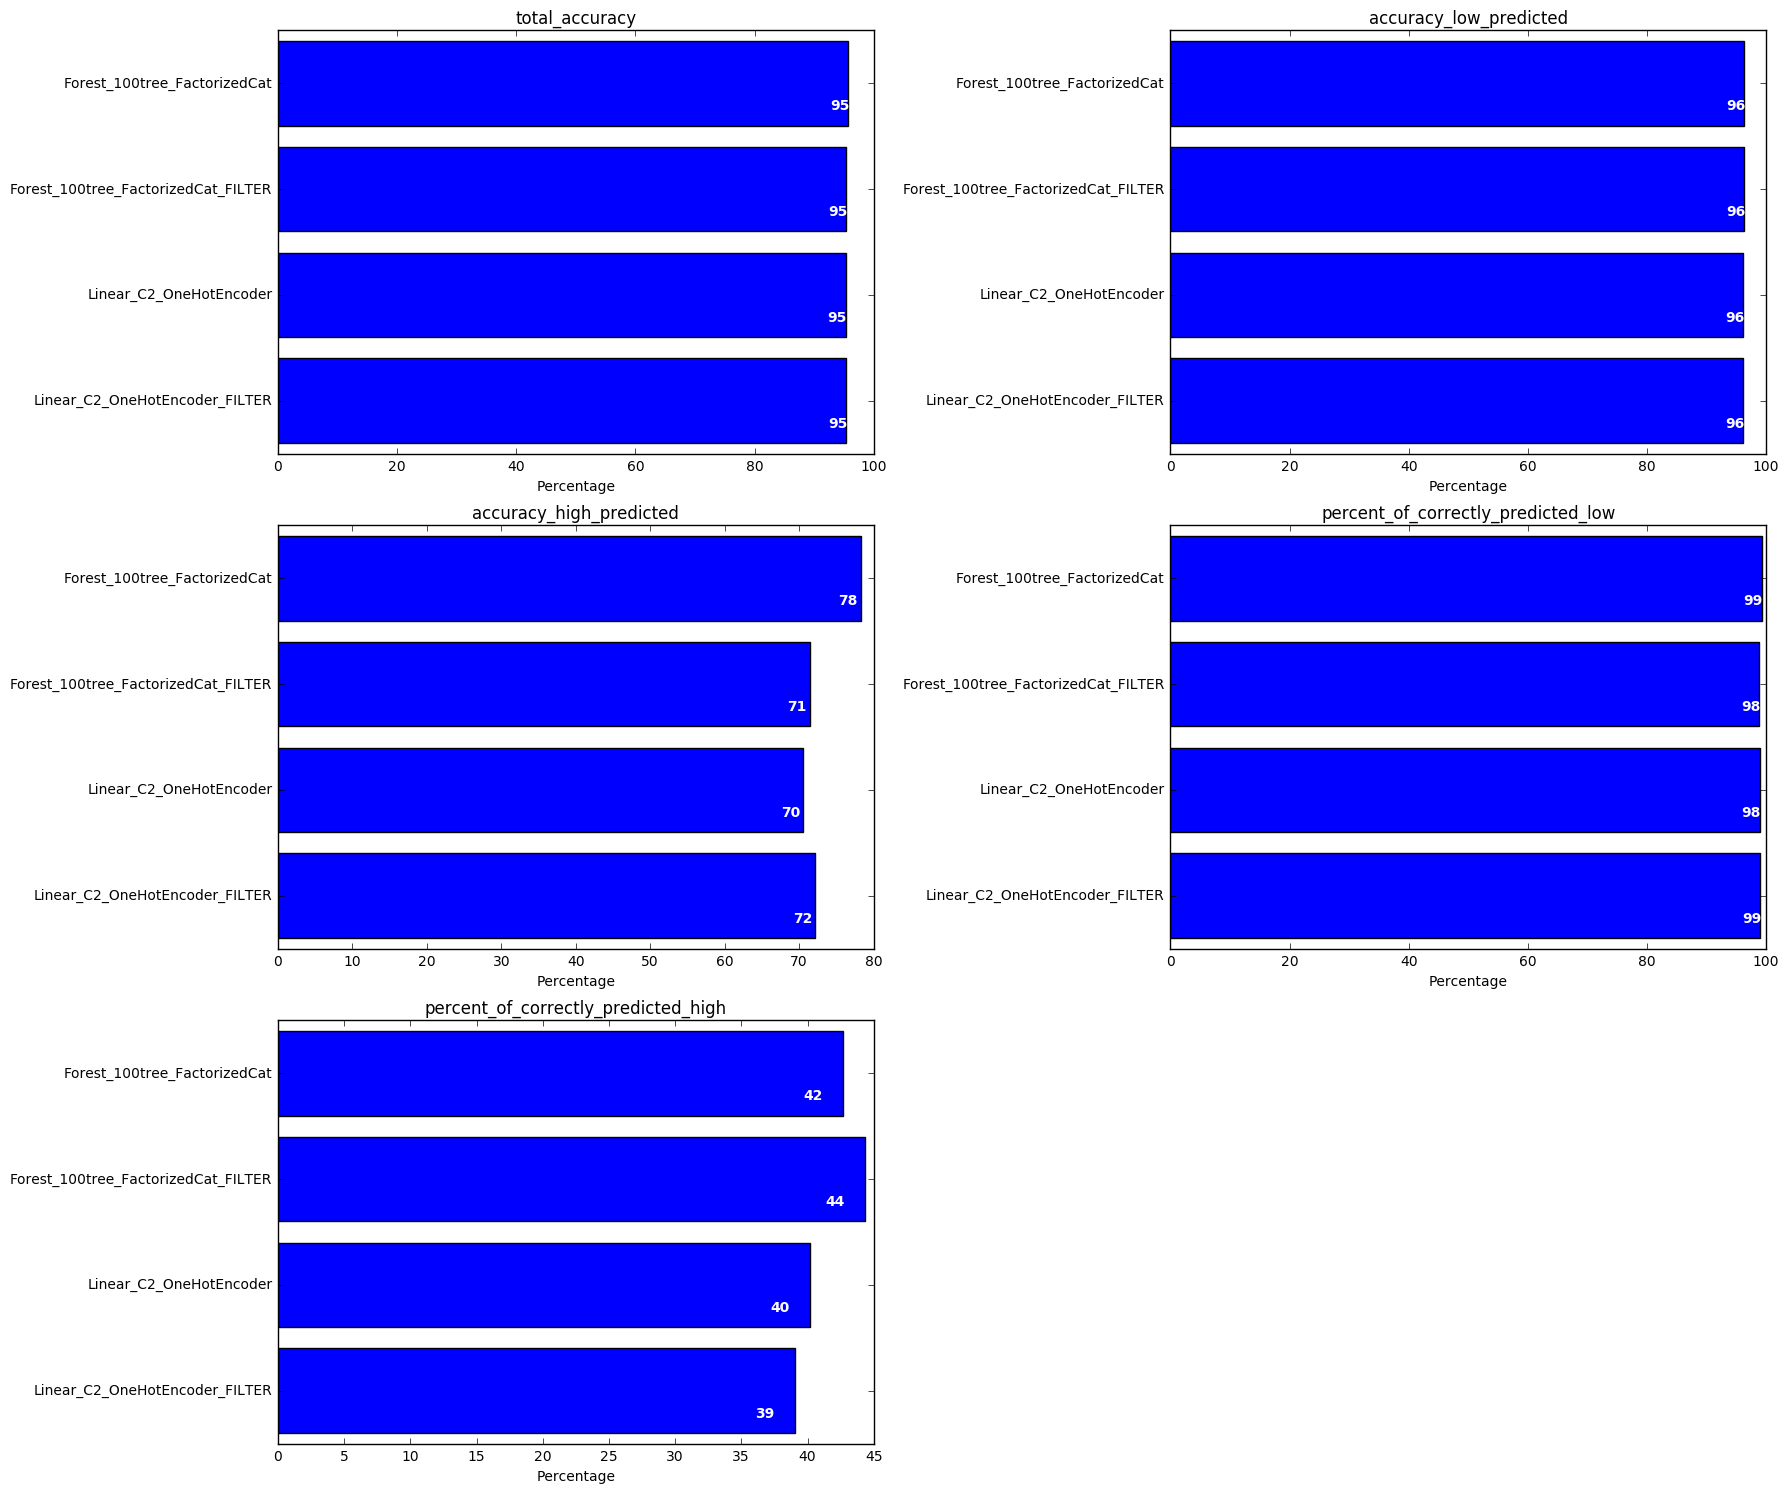

In [24]:
plt.gcf().clear()

fig = plt.figure(figsize=(18, 15), dpi= 80, facecolor='w', edgecolor='k')
total_nb = len( df)
for i in range(5) :

    stat = stats_list[i]
    ax1 = fig.add_subplot(3,2,i+1)
    
    labels = []
    sizes = []
    
    for arg in sorted(output[stat]) :
        labels.append(arg)
        sizes.append(output[stat][arg])
    
    y_pos = np.arange(len(labels))
    ax1.barh(y_pos, sizes, align='center', color='blue', ecolor='black')
    ax1.set_title(stat);
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Percentage')    
    
    for i, v in enumerate(sizes):
        ax1.text(v -3 , i + .25, str(int(v)), color='white', fontweight='bold')
    
plt.tight_layout()
plt.show()

## Feature Selection results

Results show that filtering does not improve accuracy on linear and decreases accuracy on Random Forest. We can however observe speed gains of 40%!<br>
We will use the filtered version going forward.

# 7. Results validation on the testing set

Here we train the algo on the full training set and test it on the separate testing set. We use both algos Linear_C2_OneHotEncoder_FILTER and Forest_100tree_FactorizedCat_FILTER to save processing time on the larger dataset.

In [25]:
# we apply to the validation data the same header and preprocessing as for the training data
valid_df = pd.read_csv('./us_census_full/census_income_test.csv',index_col=False, header=None)
valid_df.columns = mapping['feat'].tolist()
valid_df['income'] = pd.factorize(valid_df['income'])[0]

# we concatenate both files in order to re use the previous function
len_training = len(df)
print(len(df))
df = pd.concat([df,valid_df[1:]])
print(len(df),len(valid_df))

###### Model Validation Function
# Input : model parameters and filters
# output : model validation performance

def model_validation(args):
    
    model,reg,include_nominal_flag,one_hot_flag,filters = args
    

    # Classifier setup
    if model == 'LR' :
        classifier = LogisticRegression(C= reg)
    elif model == 'RF' :
        classifier = RandomForestClassifier(n_estimators=reg, n_jobs = 6)
    
    # Categorical Features processing
    if include_nominal_flag == False :
        #Applying input filter on feature
        new_df  = df.drop(filters, axis=1)
        train_df = new_df[list_continuous_feat][:len_training]
        test_df = new_df[list_continuous_feat][len_training:]        
        
        
    else :   
        if one_hot_flag :    
            # we use pandas' get_dummies function to generate one hot encoding
            new_df = pd.concat([pd.get_dummies(df[list_categorical_feat].astype(str)),df[list_continuous_feat]], axis=1)
            # filtering OHE categories found during correlation analysis
            new_df = new_df.drop(filter_OHE, axis=1)
        else :
            new_df = df.copy()
            for feat in list_categorical_feat :
                new_df[feat] = pd.factorize(df[feat])[0]

        #Applying input filter on feature
        new_df  = new_df.drop(filters, axis=1)
        train_df = new_df[:len_training]
        test_df = new_df[len_training:]        

    # Training
    train_data = train_df.values
    classifier.fit(train_data[:,:-1], train_data[:,-1] )
    
    # Testing
    test_data = test_df.drop(['income'],axis = 1).values
    prediction = classifier.predict(test_data)
    conf = pd.crosstab(test_df['income'], prediction, rownames=['Test Data'], colnames=['Predictions->']) 
    
    # Features Importance computation
    features_importance = []
    
    if model == 'LR' :       
        features_importance = np.stack([test_df.drop(['income'],axis = 1).columns.tolist(),np.std(test_data, 0)*classifier.coef_[0]]).transpose()
        features_importance = features_importance[np.abs(pd.to_numeric(features_importance[:,1])).argsort()[::-1]]

    elif model == 'RF' :
        sorted_indexes = np.argsort(classifier.feature_importances_)[::-1]
        for index in sorted_indexes :
            features_importance.append([test_df.drop(['income'],axis = 1).columns.tolist()[index],classifier.feature_importances_[index]])
        features_importance = np.array(features_importance)
    
    # End
    return conf,features_importance


199523
299284 99762


In [26]:
arg_dico = {
    'Linear_C2_OneHotEncoder_FILTER_VALID' : ('LR',2,True,True,linear_filter), 
    'Forest_100tree_FactorizedCat_FILTER_VALID' : ('RF',100,True,False,forest_filter)        
}

output = {}
stats_list = ['total_accuracy','accuracy_low_predicted' ,'accuracy_high_predicted',\
              'percent_of_correctly_predicted_low','percent_of_correctly_predicted_high']

for stat in stats_list :
    output[stat] = {}

feat_output = {}

#run the final model validation function over the 2 arguments
for arg in arg_dico :
    start_time = time.time()
    conf,feat_importance = model_validation(arg_dico[arg])
    output['total_accuracy'][arg] = (conf[0][0]+conf[1][1])/len(valid_df)*100 
    output['accuracy_low_predicted'][arg] = (conf[0][0]/(conf[0][0]+conf[0][1])*100 )  
    output['accuracy_high_predicted'][arg] = (conf[1][1]/(conf[1][0]+conf[1][1])*100 )  
    output['percent_of_correctly_predicted_low'][arg] = (conf[0][0]/(conf[0][0]+conf[1][0])*100 )  
    output['percent_of_correctly_predicted_high'][arg] = (conf[1][1]/(conf[0][1]+conf[1][1])*100 ) 
    feat_output[arg] = feat_importance.tolist()
    print('Processing time for '+arg+':', int(time.time()-start_time),'secs.' )

Processing time for Forest_100tree_FactorizedCat_FILTER_VALID: 8 secs.
Processing time for Linear_C2_OneHotEncoder_FILTER_VALID: 15 secs.


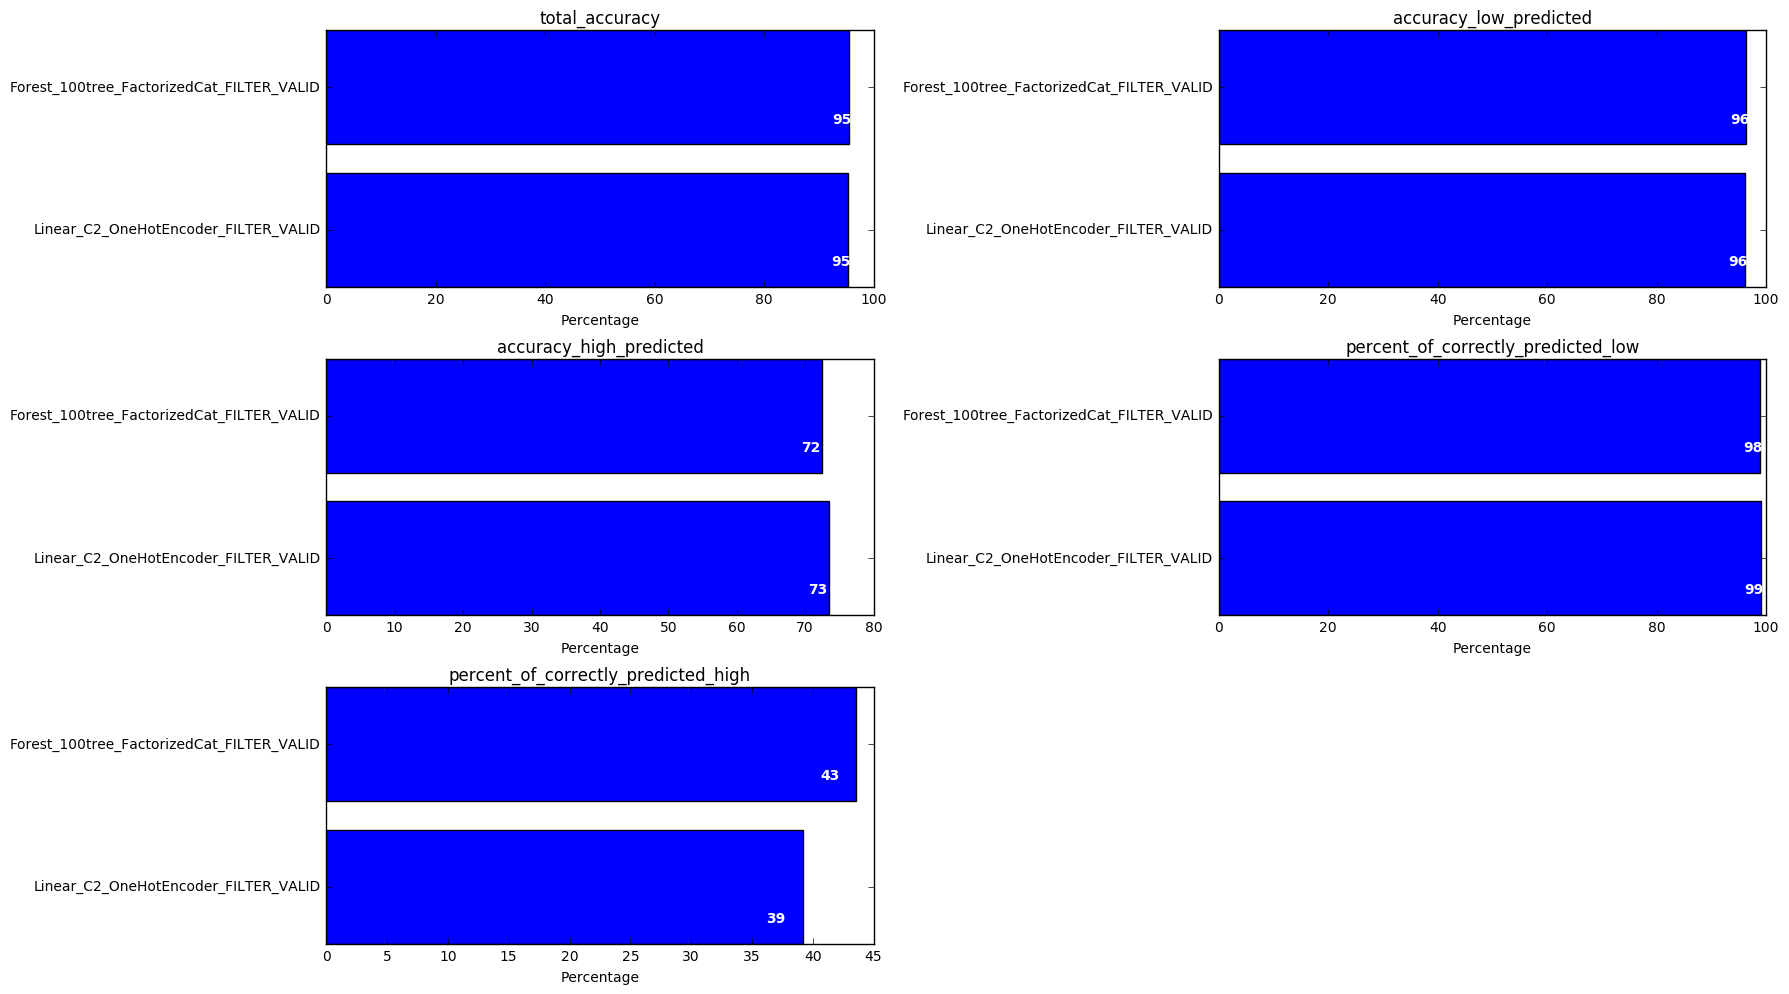

In [27]:
plt.gcf().clear()

fig = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
total_nb = len( df)
for i in range(5) :

    stat = stats_list[i]
    ax1 = fig.add_subplot(3,2,i+1)
    
    labels = []
    sizes = []
    
    for arg in sorted(output[stat]) :
        labels.append(arg)
        sizes.append(output[stat][arg])
    
    y_pos = np.arange(len(labels))
    ax1.barh(y_pos, sizes, align='center', color='blue', ecolor='black')
    ax1.set_title(stat);
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Percentage')    
    
    for i, v in enumerate(sizes):
        ax1.text(v -3 , i + .25, str(int(v)), color='white', fontweight='bold')
    
plt.tight_layout()
plt.show()

## Validation results

The results roughly correspond to the figures computed during the model selection phase.
It means that the computed accuracy is good indicator of the algos' real predictive power.

## High Income profiling

The most simple way to profile high income individuals is to analyze the list of features weights within the linear model. <br>
Features weights on Random forest does not show wether the impact is positive or negative, so we would have to select and display an individual tree.

In [29]:
feat_output['Linear_C2_OneHotEncoder_FILTER_VALID'][:40]

[['weeks worked in year', '0.9007027611310693'],
 ['tax filer stat_ Nonfiler', '-0.8265497203659472'],
 ['age', '0.7053500268573828'],
 ['full or part time employment stat_ Children or Armed Forces',
  '-0.56185429229425'],
 ['sex_ Male', '0.5479289091948055'],
 ['capital gains', '0.45312929139519126'],
 ['live in this house 1 year ago_ Not in universe under 1 year old',
  '-0.4413373448018994'],
 ['year_95', '-0.43056519792451403'],
 ['num persons worked for employer', '0.42948972987146483'],
 ['family members under 18_ Not in universe', '-0.3831324009199158'],
 ['veterans benefits_2', '-0.3513178567231421'],
 ['detailed household summary in household_ Child under 18 never married',
  '-0.3456928666848487'],
 ['detailed household and family stat_ Child <18 never marr not in subfamily',
  '-0.3438341687585046'],
 ['dividends from stocks', '0.3309037750436935'],
 ['marital stat_ Married-civilian spouse present', '-0.3168945109598923'],
 ['education_ Children', '-0.2967175352893321'],
 [

As previously observed, most predictors of individual income are not surprising :
- number of weeks worked in a year is the most positively correlated with income
- persons which do not file tax tend to have a low income
- as mentioned in numerous studies, men earn more than women in average
- capital gains, dividends from stocks, degree levels (Masters, then Bachelors) are a good indicator of high income

Some other indicators give good insights (ie we learn something from the data):
- income seems to be higher in 1995 than in 1994 
- being 'Never married' leads to lower income (-0.15)
- capital losses is positively correlated to income. If you lose money by playing with the stock market and hence decrease your income, it means that you are probably still in the higher income category

And some others are more difficult to understand:
- Impact on income is higher if your mother is from Mexico (+0.11) rather than if your father is from Mexico (-0.088). It could be interesting to dig deeper into this.


# Next Steps

Some additional work could be done to increase accuracy and performance.
For instance, Linear and Random Forest seem to rely on different features. It could be a good idea to combine both in a single model.<br>
We also could use unsupervised learning to create more efficient features:
- PCA to further reduce the number of features, 
- create 'group of similar individuals' with clustering

Thanks for reading!!